<a href="https://colab.research.google.com/github/iviiviii/yujin/blob/main/%EC%84%9C%EC%9A%B8%EC%8B%9C%EB%94%B0%EB%A6%89%EC%9D%B4%EB%8C%80%EC%97%AC%EB%9F%89%EC%98%88%EC%B8%A1_%EC%BA%90%EA%B8%80_%EC%B5%9C%EC%A2%85%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import warnings
from scipy.stats import probplot
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 분석
- id : 고유 id
- hour : 시간
- temperature : 기온
- precipitation : 비가 오지 않았으면 0, 비가 오면 1
- windspeed : 풍속(평균)
- humidity : 습도
- visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone : 오존
- pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count : 시간에 따른 따릉이 대여 수

In [ ]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0




---



결측치 확인

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64


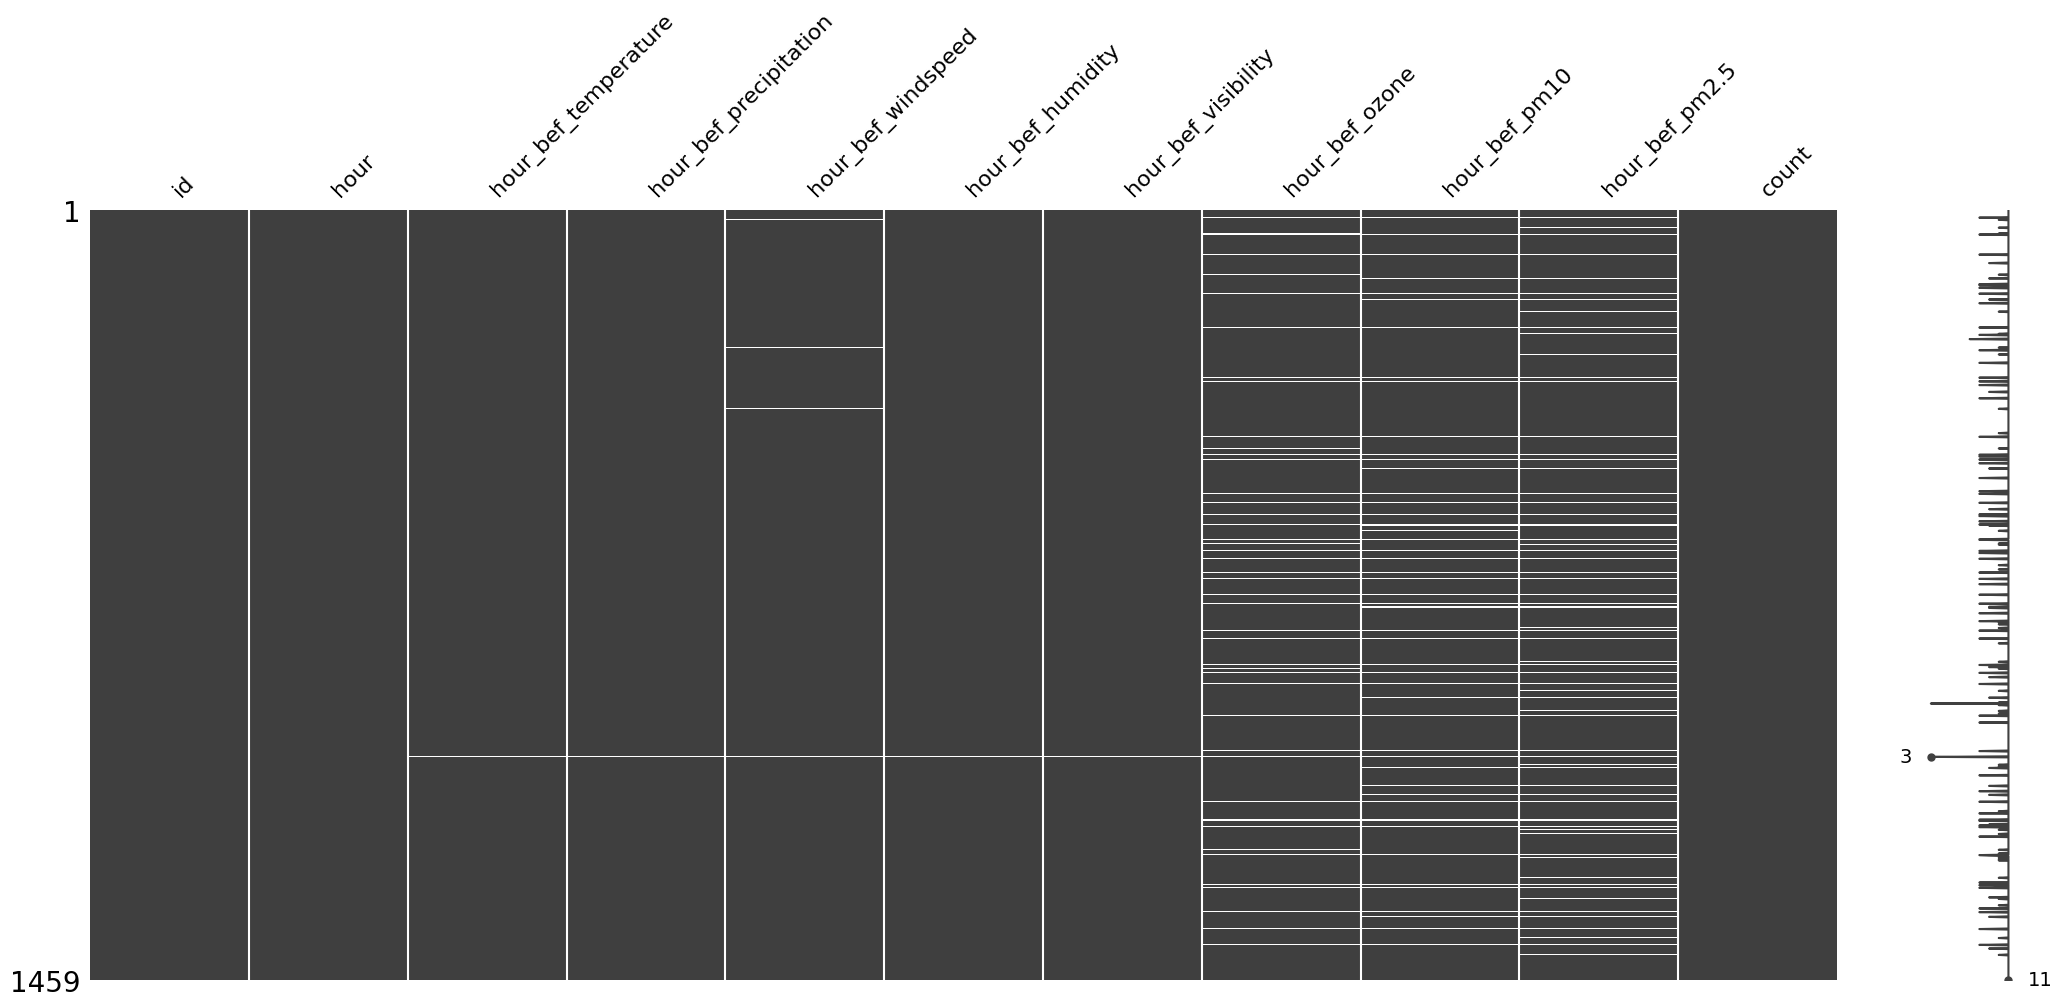

In [ ]:
#msno는 결측치 시각화
msno.matrix(train)
print(train.isnull().sum())

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64


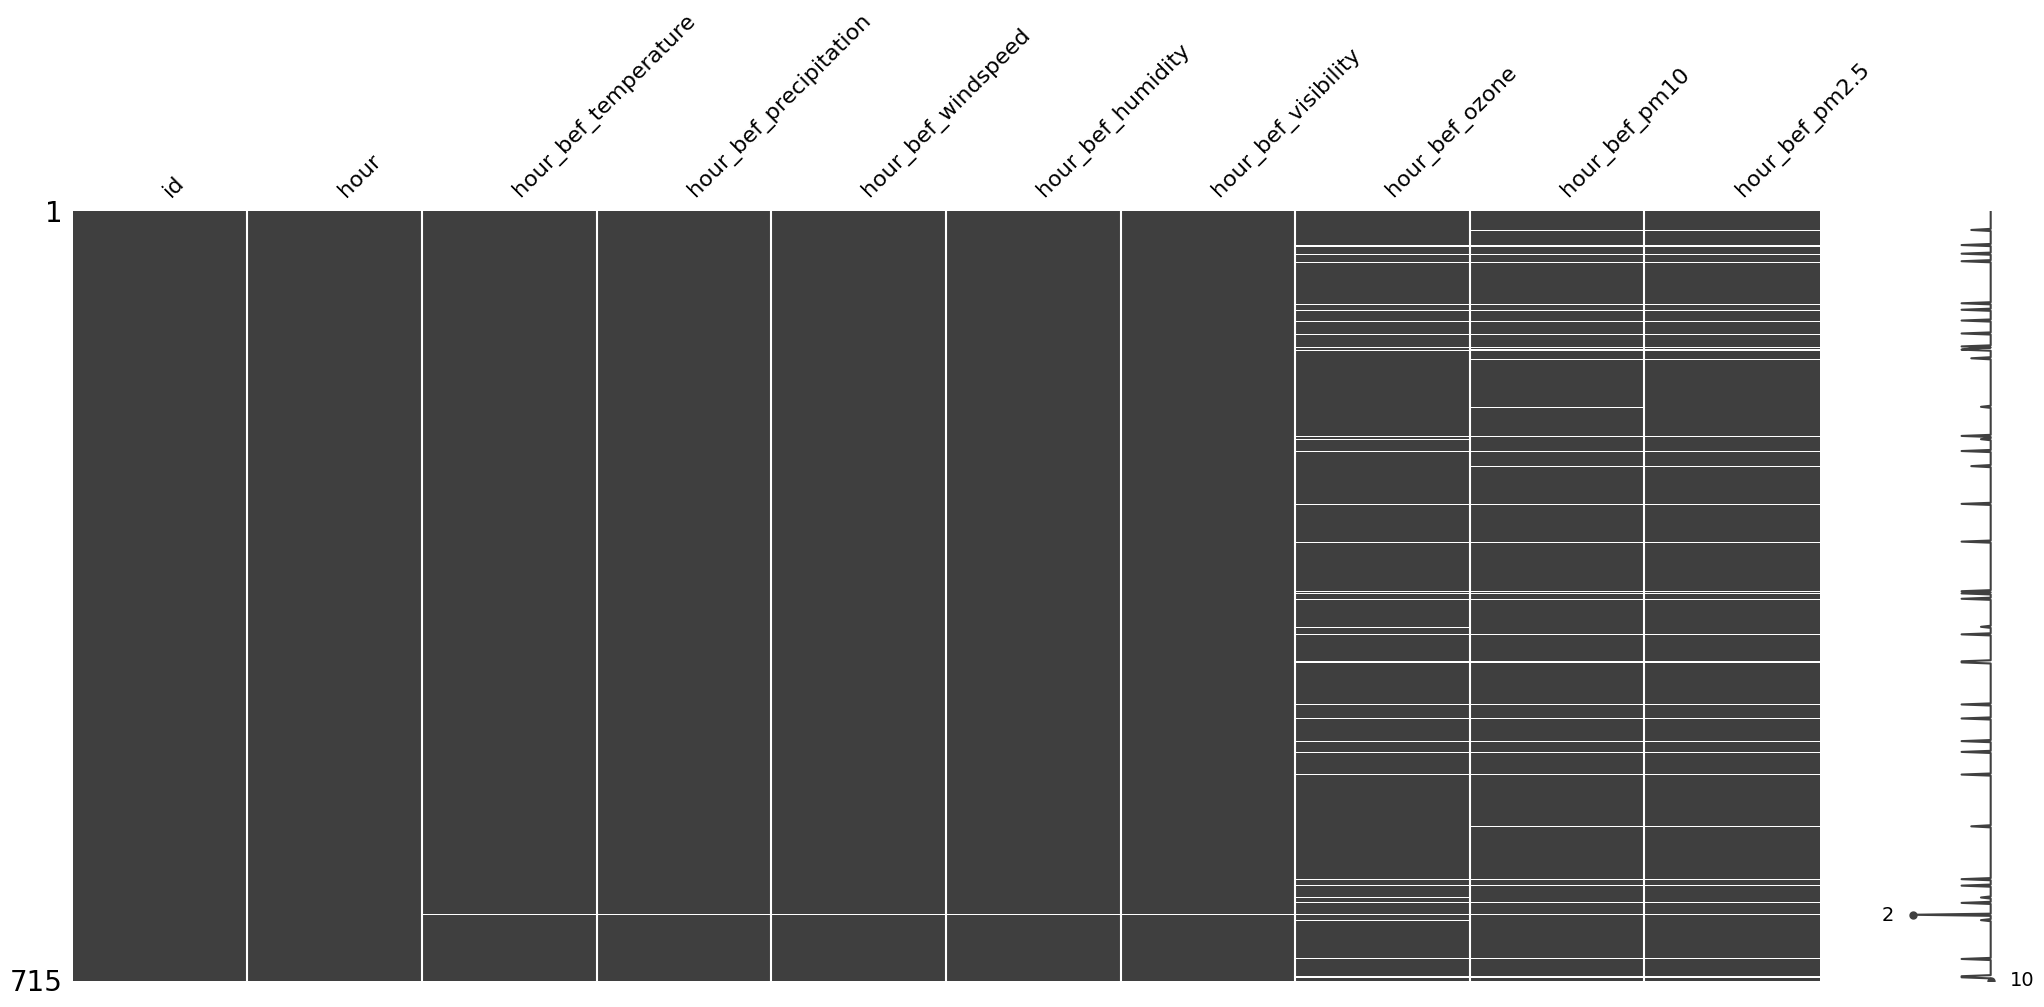

In [ ]:
msno.matrix(test)
print(test.isnull().sum())



---



특징별 상관관계 확인

<Axes: >

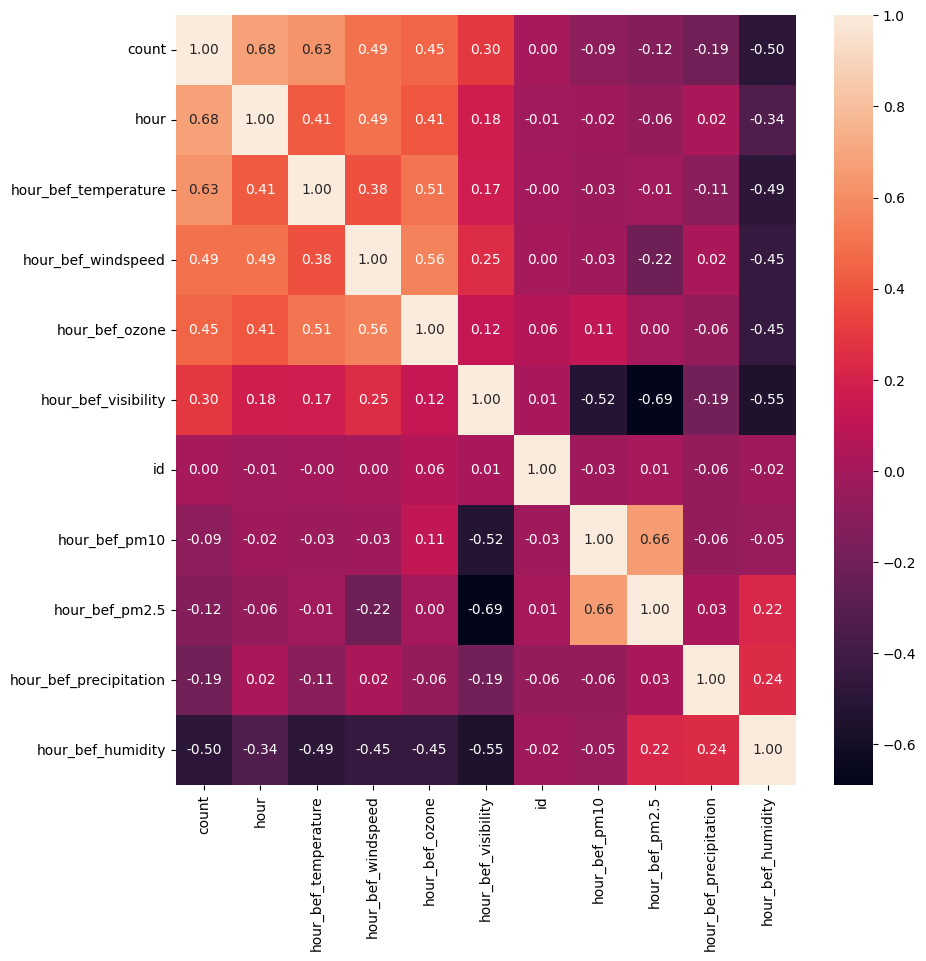

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
corrmat = train.corr(method='spearman')
indexes = corrmat.nlargest(n=11, columns='count').index #count열 기준으로 내림차순했을 때 상위 11개 행 선택
corrmat = train[indexes].corr(method='spearman')
sns.heatmap(data=corrmat, annot=True, cbar=True, fmt='.2f', ax=ax)

종속변수인 따릉이 대여량 count와 관련된 상관관계를 분석
- 따릉이를 대여한 시간 hour 가 양(+)의 상관관계
- 빌린날의 온도 hour_bef_temperature는 강한 양의 상관관계. 기온이 높을수록 대여량이 늘어남.
- 습도를 의미하는 hour_bef_humidity는 음의 상관관계. 습도가 낮을수록 대여량 늘어남

# 1. 시각화

1.0. 종속변수 시각화 : count(대여량)

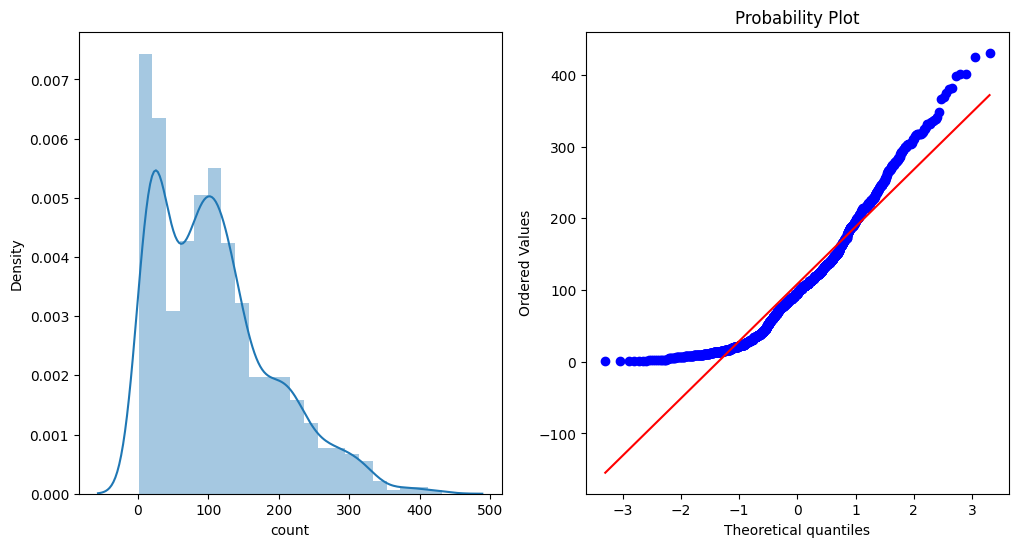

In [ ]:
data = train['count']
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(data, ax=axes[0])
probplot(data, plot=axes[1])
plt.show()

거의 선형성을 보입니다. 살짝 왼쪽으로 분포가 치우친 경향이 있는데, 1/3 제곱을 하여 정규분포에 가깝게 맞추어 주도록 하겠습니다.

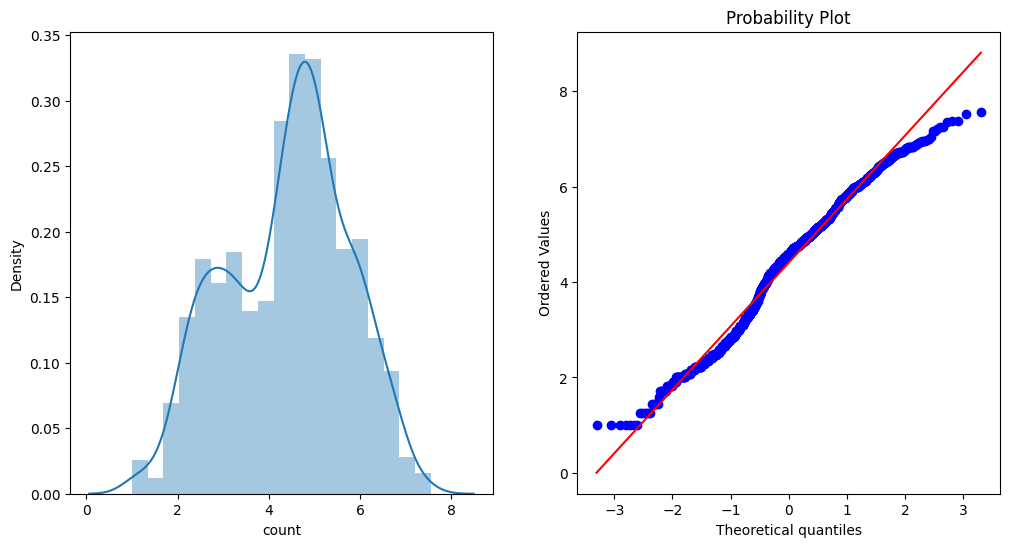

In [ ]:
# 재표현
data = np.power(train['count'], 1/3)
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.distplot(data, ax=axes[0])
probplot(data, plot=axes[1])
plt.show()

보다 정규분포에 가까워짐

1.1.독립변수 시각화 : hour(시간)

<Axes: xlabel='hour', ylabel='count'>

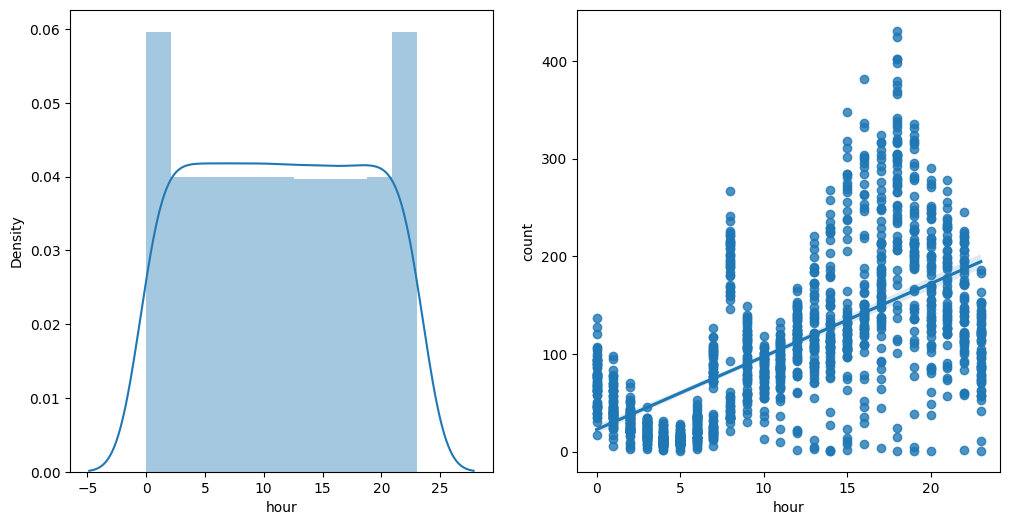

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(a=train['hour'], ax=axes[0])
sns.regplot(data=train, x='hour', y='count', ax=axes[1])

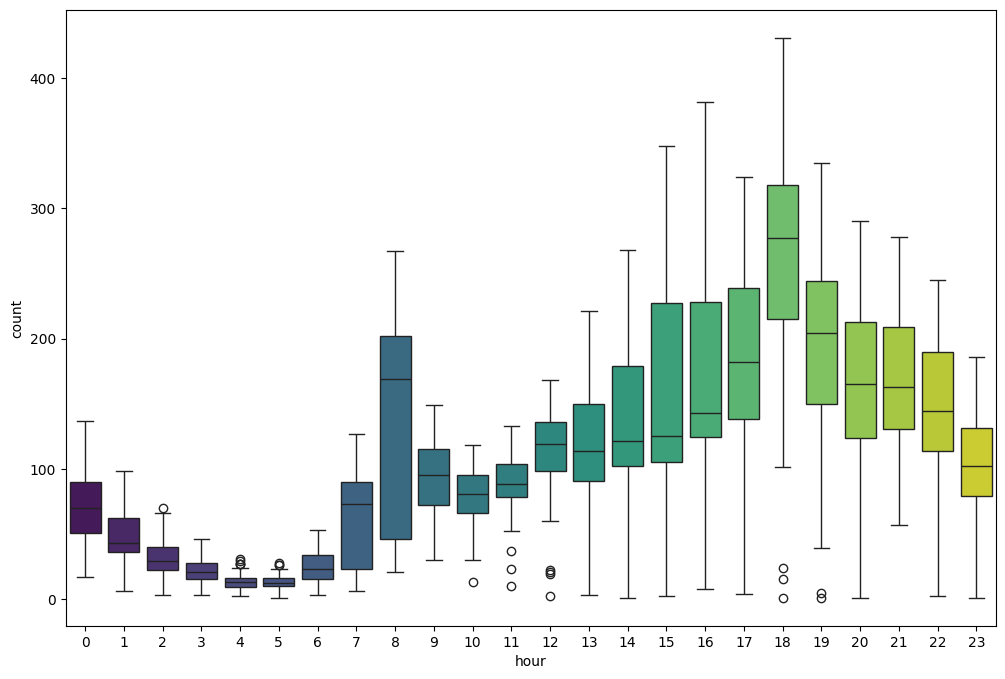

In [ ]:
color_palette = sns.color_palette("viridis", n_colors=len(train['hour'].unique()))

fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.boxplot(data=train, x='hour', y='count', palette=color_palette)
# 그래프 표시
plt.show()

# 2. 데이터 전처리

2.1 결측치 처리

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
# 결측치인 행의 인덱스 반환
print("temp가 결측치인 행 인덱스:", train['hour_bef_temperature'][train['hour_bef_temperature'].isnull()])
print("humidity가 결측치인 행 인덱스:", train['hour_bef_humidity'][train['hour_bef_humidity'].isnull()])

## -> 934, 1035 행의 temp와 humidity 모두 null

temp가 결측치인 행 인덱스: 934    NaN
1035   NaN
Name: hour_bef_temperature, dtype: float64
humidity가 결측치인 행 인덱스: 934    NaN
1035   NaN
Name: hour_bef_humidity, dtype: float64


In [ ]:
train.loc[[934,1035]]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


934번째 행과 1035번째 행은 id, hour말고는 전부 비어있어서 같은 count(39, 1)의 특징값들의 평균으로 채워주자

In [ ]:
# count가 39값으로 934번째 행 채우기
fill_value_a = train[(train['count'] == 39) & (train.isnull().sum(axis=1) == 0)].mean()

# fill_value에서 temp ~ count값으로 채우기
train.iloc[934, 2:-1] = fill_value_a.iloc[2:-1]

In [ ]:
# count가 1값으로 1035번째 행 채우기
fill_value_b = train[(train['count'] == 1) & (train.isnull().sum(axis=1) == 0)].mean()

# fill_value에서 temp ~ count값으로 채우기
train.iloc[1035, 2:-1] = fill_value_b.iloc[2:-1]

In [ ]:
#확인
train[(train['count']==1) | (train['count']==39)]  #934, 1035번째행 존재

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
5,13,2,13.60,0.0,1.7,80.0,1073.0,0.0270,34.0,15.0,39.0
8,19,9,13.80,0.0,1.9,64.0,1344.0,0.0390,93.0,19.0,39.0
84,130,1,9.40,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
306,476,19,10.80,1.0,3.9,92.0,250.0,0.0320,34.0,28.0,1.0
374,568,7,12.80,0.0,1.4,84.0,235.0,0.0310,114.0,67.0,39.0
583,894,14,14.40,1.0,3.5,79.0,1395.0,0.0390,41.0,28.0,1.0
666,1018,5,10.80,0.0,3.3,98.0,91.0,0.0360,32.0,24.0,1.0
671,1024,2,17.40,0.0,1.3,44.0,1319.0,0.0230,68.0,41.0,39.0
708,1080,1,11.60,0.0,0.6,52.0,1853.0,NaN,NaN,NaN,39.0
713,1085,19,16.70,1.0,0.7,88.0,577.0,0.0370,82.0,37.0,39.0


In [ ]:
# test값 확인
test[test.isnull().sum(axis=1) > 1]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,42,18,29.4,0.0,3.3,43.0,1685.0,0.055,NaN,NaN
32,82,1,22.8,0.0,2.4,52.0,2000.0,NaN,NaN,NaN
40,115,1,21.5,1.0,0.5,90.0,347.0,NaN,NaN,NaN
47,147,1,22.8,0.0,1.2,57.0,1190.0,NaN,NaN,NaN
86,260,1,20.0,0.0,2.0,65.0,1662.0,NaN,NaN,NaN
92,270,1,20.0,0.0,1.7,31.0,2000.0,NaN,NaN,NaN
102,297,1,15.1,1.0,2.2,98.0,224.0,NaN,NaN,NaN
114,323,1,18.7,0.0,1.4,41.0,2000.0,NaN,NaN,NaN
126,352,1,19.2,0.0,1.4,80.0,1085.0,NaN,NaN,NaN
128,356,15,25.5,0.0,3.6,40.0,1404.0,0.077,NaN,NaN


In [ ]:
# preci가 0,1만 있어야되는데 0.2, 0.8값 존재함
train['hour_bef_precipitation'].value_counts()
# 값 찾기
# train[train['hour_bef_precipitation']==0.2] # 행 934
# train[train['hour_bef_precipitation']==0.8] # 행 1035
train.iloc[934,3] = 0
train.iloc[1035,3] = 1

In [ ]:
# 결측치 처리(훈련데이터)
fill_data = train.groupby('hour_bef_precipitation').mean()
fill_data

,id,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
hour_bef_precipitation,,,,,,,,,,
0.0,1112.024788,11.461756,16.807833,2.472598,51.229462,1427.705807,0.039361,57.470429,30.319110,111.079320
1.0,922.340426,12.446809,13.864255,2.674468,83.497872,705.502128,0.032436,47.590476,30.639024,32.978723


In [ ]:
# 테스트 데이터 중 id, hour를 빼고 다 NaN값인 653번 인덱스의 값을
#fill_value_a (count가 39인 나머지 변수들의 평균값)로 채워줌
test.iloc[653, 2:] = fill_value_a[2:-1]

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          7
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             74
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64
id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            34
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64


In [ ]:
#null_columns = ['hour_bef_windspeed', 'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']
#결측치 채우기
#for c in null_columns:
#    train[c][train['hour_bef_precipitation']==0] = train[c][train['hour_bef_precipitation']==0].fillna(fill_data[c].iloc[0], axis=0)
#    train[c][train['hour_bef_precipitation']==1] = train[c][train['hour_bef_precipitation']==1].fillna(fill_data[c].iloc[1], axis=0)
#    test[c][test['hour_bef_precipitation']==0] = test[c][test['hour_bef_precipitation']==0].fillna(fill_data[c].iloc[0], axis=0)
#    test[c][test['hour_bef_precipitation']==1] = test[c][test['hour_bef_precipitation']==1].fillna(fill_data[c].iloc[1], axis=0)
#확인
#train.isnull().sum(), test.isnull().sum()

## 2.2 재표현
- 종속변수(count) 1/3제곱으로 변환해주기
- 가시성(visibility) 세구간으로 나누기


종속변수count 재표현

In [ ]:
data = np.power(train['count'], 1/3)
train['count'] = data

가시성 재표현

In [ ]:
def set_visibility(x):
    if x >= 0.8:
        return 2
    elif x >= 0.2 :
        return 1
    else:
        return 0

In [ ]:
# train 데이터
data = train.copy()
data['hour_bef_visibility'] = np.power(data['hour_bef_visibility'], 3)
data['hour_bef_visibility'] /= np.max(data['hour_bef_visibility'])
data['visibility'] = data['hour_bef_visibility'].map(set_visibility)
# 확인
print(data['visibility'].value_counts())

train['visibility'] = data['visibility']

2    560
0    543
1    356
Name: visibility, dtype: int64


In [ ]:
# test 데이터
data = test.copy()
data['hour_bef_visibility'] = np.power(data['hour_bef_visibility'], 3)
data['hour_bef_visibility'] /= np.max(data['hour_bef_visibility'])
data['visibility'] = data['hour_bef_visibility'].map(set_visibility)
#확인
print(data['visibility'].value_counts())
test['visibility'] = data['visibility']

0    284
2    262
1    169
Name: visibility, dtype: int64


풍속, 오존, 미세먼지(pm10,2.5) 재표현
~

In [ ]:
# 풍속 재표현
train['hour_bef_windspeed'] = np.power(train['hour_bef_windspeed'], 1/2)
test['hour_bef_windspeed'] = np.power(test['hour_bef_windspeed'], 1/2)

# 오존 재표현
train['hour_bef_ozone'] = np.power(train['hour_bef_ozone'], 1/2)
test['hour_bef_ozone'] = np.power(test['hour_bef_ozone'], 1/2)

# 미세먼지 (pm10,pm2.5)
train['hour_bef_pm10'] = np.log1p(train['hour_bef_pm10'])
test['hour_bef_pm10'] = np.log1p(test['hour_bef_pm10'])
train['hour_bef_pm2.5'] = np.log1p(train['hour_bef_pm2.5'])
test['hour_bef_pm2.5'] = np.log1p(test['hour_bef_pm2.5'])

필요없는 칼럼 버리기

In [ ]:
drop_columns = ['id', 'hour_bef_visibility']
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

In [ ]:
train.drop(columns='count')

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,visibility
0,20,16.3,1.0,1.224745,89.0,0.164317,4.343805,3.526361,0
1,13,20.1,0.0,1.183216,48.0,0.204939,4.304065,3.713572,0
2,6,13.9,0.0,0.836660,79.0,0.181659,3.496508,2.995732,1
3,23,8.1,0.0,1.643168,54.0,0.200000,4.330733,4.174387,0
4,18,29.5,0.0,2.190890,7.0,0.238747,3.332205,2.484907,2
...,...,...,...,...,...,...,...,...,...
1454,4,16.8,0.0,1.264911,53.0,0.176068,3.637586,3.332205,2
1455,3,10.8,0.0,1.949359,45.0,0.197484,3.555348,2.995732,2
1456,5,18.3,0.0,1.378405,54.0,0.094868,3.433987,3.091042,2
1457,21,20.7,0.0,1.923538,37.0,0.286356,4.276666,3.610918,1


# 2.5 범위 표준화

In [ ]:
train.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone',
       'hour_bef_pm10', 'hour_bef_pm2.5', 'count', 'visibility'],
      dtype='object')

In [ ]:
obj_columns = ['hour_bef_temperature',
               'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone',
               'hour_bef_pm10', 'hour_bef_pm2.5']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train[obj_columns])
train[obj_columns] = minmax_scaler.transform(train[obj_columns])
test[obj_columns] = minmax_scaler.transform(test[obj_columns])

# 2.6 원핫인코딩

In [ ]:
train['hour'].unique()

array([20, 13,  6, 23, 18,  2,  3, 21,  9, 14,  4, 10,  1, 17,  8, 16,  0,
        7, 15, 19, 22, 11,  5, 12])

In [ ]:
train

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,visibility
0,20,0.490706,1.0,0.433013,0.891304,0.366638,0.619333,0.574480,3.659306,0
1,13,0.631970,0.0,0.418330,0.445652,0.502598,0.607275,0.655396,5.417502,0
2,6,0.401487,0.0,0.295804,0.782609,0.424681,0.362252,0.345131,2.962496,1
3,23,0.185874,0.0,0.580948,0.510870,0.486067,0.615367,0.854570,3.848501,0
4,18,0.981413,0.0,0.774597,0.000000,0.615750,0.312400,0.124342,7.553689,2
...,...,...,...,...,...,...,...,...,...,...
1454,4,0.509294,0.0,0.447214,0.500000,0.405969,0.405057,0.490561,2.758924,2
1455,3,0.286245,0.0,0.689202,0.413043,0.477647,0.380105,0.345131,2.714418,2
1456,5,0.565056,0.0,0.487340,0.510870,0.134199,0.343282,0.386326,2.802039,2
1457,21,0.654275,0.0,0.680074,0.326087,0.775096,0.598962,0.611027,6.000000,1


### hour에 대해 원핫인코딩 수행! 하기전에 hour=1일때의 결측치 제거

train

In [ ]:
# 'hour' 열을 제외한 나머지 특성들을 선택
features_to_fill = train.drop(columns=['hour','hour_bef_temperature','hour_bef_precipitation','hour_bef_humidity'])

# 각 'hour' 값에 대한 평균 계산
hourly_means = features_to_fill.groupby(train['hour']).mean()

# 결측값을 해당 시간대의 평균 값으로 대체
for hour_value in hourly_means.index:
    # 해당 시간대의 행 선택
    rows_to_fill = (train['hour'] == hour_value)

    # 해당 시간대의 평균 값으로 결측값 대체
    train.loc[rows_to_fill, features_to_fill.columns] = train.loc[rows_to_fill, features_to_fill.columns].fillna(hourly_means.loc[hour_value])

train.isna().sum()

hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_ozone            61
hour_bef_pm10             61
hour_bef_pm2.5            61
count                      0
visibility                 0
dtype: int64

In [ ]:
##hour=1일 때 세 행 모두 61개의 값이 null!!!! -> visibility가 그나마 나머지 세 행이랑 연관성 잇어보임
#->visibility에 따라 결측치 대체

columns_to_check = ['hour_bef_windspeed','hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']

# null값을 가진 행을 선택
rows_with_null = train[train[columns_to_check].isnull().any(axis=1)]

# 결과 출력
rows_with_null

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,visibility
14,1,0.628253,0.0,0.474342,0.554348,NaN,NaN,NaN,4.198336,2
46,1,0.338290,0.0,0.612372,0.456522,NaN,NaN,NaN,3.301927,0
84,1,0.234201,0.0,0.559017,0.630435,NaN,NaN,NaN,3.391211,2
142,1,0.583643,0.0,0.370810,0.586957,NaN,NaN,NaN,3.957892,2
147,1,0.568773,0.0,0.622495,0.260870,NaN,NaN,NaN,3.979057,2
...,...,...,...,...,...,...,...,...,...,...
1283,1,0.501859,0.0,0.512348,0.304348,NaN,NaN,NaN,3.957892,2
1322,1,0.446097,0.0,0.403113,0.304348,NaN,NaN,NaN,3.419952,2
1329,1,0.542751,0.0,0.353553,0.391304,NaN,NaN,NaN,4.101566,1
1361,1,0.353160,0.0,0.547723,0.445652,NaN,NaN,NaN,3.503398,1


In [ ]:
visibility_means = train.groupby('visibility').mean()
# hour가 1이고 visibility가 0, 1, 2인 행 선택
rows_to_fill = (train['hour'] == 1)
# 결측치를 해당 visibility의 평균 값으로 대체
for column in ['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']:
    train.loc[rows_to_fill, column] = train.loc[rows_to_fill, column].fillna(
        train.loc[rows_to_fill, 'visibility'].map(visibility_means[column])
    )
train[train['hour']==1]

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,visibility
14,1,0.628253,0.0,0.474342,0.554348,0.472497,0.412878,0.360427,4.198336,2
46,1,0.338290,0.0,0.612372,0.456522,0.426925,0.570748,0.631370,3.301927,0
84,1,0.234201,0.0,0.559017,0.630435,0.472497,0.412878,0.360427,3.391211,2
142,1,0.583643,0.0,0.370810,0.586957,0.472497,0.412878,0.360427,3.957892,2
147,1,0.568773,0.0,0.622495,0.260870,0.472497,0.412878,0.360427,3.979057,2
...,...,...,...,...,...,...,...,...,...,...
1283,1,0.501859,0.0,0.512348,0.304348,0.472497,0.412878,0.360427,3.957892,2
1322,1,0.446097,0.0,0.403113,0.304348,0.472497,0.412878,0.360427,3.419952,2
1329,1,0.542751,0.0,0.353553,0.391304,0.471493,0.524795,0.507761,4.101566,1
1361,1,0.353160,0.0,0.547723,0.445652,0.471493,0.524795,0.507761,3.503398,1


In [ ]:
# 'hour' 열을 원핫 인코딩
train = pd.concat([pd.get_dummies(train['hour'], prefix='hour'), train], axis=1)
train

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,visibility
0,0,0,0,0,0,0,0,0,0,0,...,20,0.490706,1.0,0.433013,0.891304,0.366638,0.619333,0.574480,3.659306,0
1,0,0,0,0,0,0,0,0,0,0,...,13,0.631970,0.0,0.418330,0.445652,0.502598,0.607275,0.655396,5.417502,0
2,0,0,0,0,0,0,1,0,0,0,...,6,0.401487,0.0,0.295804,0.782609,0.424681,0.362252,0.345131,2.962496,1
3,0,0,0,0,0,0,0,0,0,0,...,23,0.185874,0.0,0.580948,0.510870,0.486067,0.615367,0.854570,3.848501,0
4,0,0,0,0,0,0,0,0,0,0,...,18,0.981413,0.0,0.774597,0.000000,0.615750,0.312400,0.124342,7.553689,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,1,0,0,0,0,0,...,4,0.509294,0.0,0.447214,0.500000,0.405969,0.405057,0.490561,2.758924,2
1455,0,0,0,1,0,0,0,0,0,0,...,3,0.286245,0.0,0.689202,0.413043,0.477647,0.380105,0.345131,2.714418,2
1456,0,0,0,0,0,1,0,0,0,0,...,5,0.565056,0.0,0.487340,0.510870,0.134199,0.343282,0.386326,2.802039,2
1457,0,0,0,0,0,0,0,0,0,0,...,21,0.654275,0.0,0.680074,0.326087,0.775096,0.598962,0.611027,6.000000,1


test

In [ ]:
test.isna().sum()
# 오존(34), 10(36), 2.5(35) 세행에서 결측치

hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_ozone            34
hour_bef_pm10             36
hour_bef_pm2.5            35
visibility                 0
dtype: int64

In [ ]:
feat_to_fill = test.drop(columns=['hour','hour_bef_temperature','hour_bef_precipitation','hour_bef_windspeed','hour_bef_humidity'])

# 각 'hour' 값에 대한 평균 계산
ho_means = feat_to_fill.groupby(test['hour']).mean()

# 결측값을 해당 시간대의 평균 값으로 대체
for hour_value in ho_means.index:
    # 해당 시간대의 행 선택
    rows_to_fill = (test['hour'] == hour_value)

    # 해당 시간대의 평균 값으로 결측값 대체
    test.loc[rows_to_fill, feat_to_fill.columns] = test.loc[rows_to_fill, feat_to_fill.columns].fillna(ho_means.loc[hour_value])

test.isna().sum()

hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_ozone            30
hour_bef_pm10             30
hour_bef_pm2.5            30
visibility                 0
dtype: int64

In [ ]:
columns_to_check = ['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']

# null값을 가진 행을 선택
rows_with_null = test[test[columns_to_check].isnull().any(axis=1)]

# 결과 출력
#rows_with_null
## 얘도 마찬가지로 hour=1이 세열 다 결측치

In [ ]:
visib_means = test.groupby('visibility').mean()
# hour가 1이고 visibility가 0, 1, 2인 행 선택
rows_to_fill = (test['hour'] == 1)
# 결측치를 해당 visibility의 평균 값으로 대체
for column in ['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']:
    test.loc[rows_to_fill, column] = test.loc[rows_to_fill, column].fillna(
        test.loc[rows_to_fill, 'visibility'].map(visib_means[column])
    )

In [ ]:
#인코딩
test = pd.concat([pd.get_dummies(test['hour'], prefix='hour'), test], axis=1)
test

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_23,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,visibility
0,0,0,0,0,0,0,0,1,0,0,...,0,7,0.654275,0.0,0.403113,0.597826,0.494383,0.456357,0.490561,0
1,0,0,0,0,0,0,0,0,0,0,...,0,17,1.000000,0.0,0.821584,0.282609,0.643312,0.488325,0.611027,1
2,0,0,0,0,0,0,0,0,0,0,...,0,13,0.591078,1.0,0.512348,0.956522,0.290009,0.396965,0.505729,0
3,0,0,0,0,0,0,1,0,0,0,...,0,6,0.721190,0.0,0.559017,0.576087,0.366638,0.506004,0.633781,1
4,0,0,0,0,0,0,0,0,0,0,...,0,22,0.427509,1.0,0.651920,0.934783,0.494383,0.194747,0.248684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,1,0,0,0,0,0,0,0,0,...,0,1,0.799257,0.0,0.547723,0.576087,0.478170,0.393018,0.448594,1
711,0,1,0,0,0,0,0,0,0,0,...,0,1,0.557621,0.0,0.353553,0.521739,0.461138,0.335661,0.291602,2
712,0,0,0,0,0,0,0,0,0,1,...,0,9,0.750929,0.0,0.536190,0.641304,0.290009,0.178342,0.248684,1
713,0,0,0,0,0,0,0,0,0,0,...,0,16,0.888476,0.0,0.447214,0.423913,0.415398,0.428112,0.474843,2


# ! 추가

precipitation에 대해 원핫인코딩 수행

In [ ]:
# train 데이터
train['hour_bef_precipitation'] = train['hour_bef_precipitation'].astype('category')
train = pd.get_dummies(train, columns=['hour_bef_precipitation'], prefix='hour_bef_precipitation')
# test 데이터
test['hour_bef_precipitation'] = test['hour_bef_precipitation'].astype('category')
test = pd.get_dummies(test, columns=['hour_bef_precipitation'], prefix='hour_bef_precipitation')

In [ ]:
train

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,visibility,hour_bef_precipitation_0.0,hour_bef_precipitation_1.0
0,0,0,0,0,0,0,0,0,0,0,...,0.490706,0.433013,0.891304,0.366638,0.619333,0.574480,3.659306,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0.631970,0.418330,0.445652,0.502598,0.607275,0.655396,5.417502,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0.401487,0.295804,0.782609,0.424681,0.362252,0.345131,2.962496,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0.185874,0.580948,0.510870,0.486067,0.615367,0.854570,3.848501,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0.981413,0.774597,0.000000,0.615750,0.312400,0.124342,7.553689,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,1,0,0,0,0,0,...,0.509294,0.447214,0.500000,0.405969,0.405057,0.490561,2.758924,2,1,0
1455,0,0,0,1,0,0,0,0,0,0,...,0.286245,0.689202,0.413043,0.477647,0.380105,0.345131,2.714418,2,1,0
1456,0,0,0,0,0,1,0,0,0,0,...,0.565056,0.487340,0.510870,0.134199,0.343282,0.386326,2.802039,2,1,0
1457,0,0,0,0,0,0,0,0,0,0,...,0.654275,0.680074,0.326087,0.775096,0.598962,0.611027,6.000000,1,1,0


In [ ]:
train.drop(columns='hour', inplace=True)
test.drop(columns='hour', inplace=True)

## 5.모델 학습을 위한 데이터 분할 (K-Fold)

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train):
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

    X_train = train_fold.drop(columns=['count'])
    y_train = train_fold['count']

    X_val = val_fold.drop(columns=['count'])
    y_val = val_fold['count']

    # 6. RandomForestRegressor 모델 적용
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f'Validation RMSE: {rmse}')
print(f'Average RMSE: {np.mean(rmse)}')

Validation RMSE: 0.6374560993950135
Validation RMSE: 0.6080982617869566
Validation RMSE: 0.6726503494837829
Validation RMSE: 0.6104194277442099
Validation RMSE: 0.6010401381750995
Average RMSE: 0.6010401381750995


In [ ]:
# RandomForestRegressor모델로 특성 중요를 확인하면 이렇게 나옴

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print(feature_importances)

hour_bef_temperature          0.409295
hour_bef_windspeed            0.079657
hour_bef_humidity             0.068400
hour_5                        0.045589
hour_4                        0.045242
hour_bef_ozone                0.043328
hour_bef_pm10                 0.037684
hour_3                        0.031826
hour_18                       0.028398
hour_6                        0.027735
hour_2                        0.026303
hour_bef_pm2.5                0.026101
hour_8                        0.017593
hour_bef_precipitation_1.0    0.017478
visibility                    0.016543
hour_1                        0.011774
hour_bef_precipitation_0.0    0.011161
hour_7                        0.009429
hour_19                       0.005676
hour_22                       0.005305
hour_0                        0.004819
hour_21                       0.004795
hour_17                       0.003775
hour_13                       0.003146
hour_11                       0.002542
hour_16                  

In [ ]:
# 최근접 이웃 (KNN회귀모델)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 데이터셋을 특성과 타겟으로 나누기
X = train.drop(columns=['count'])
y = train['count']

# 훈련 데이터와 검증 데이터로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# K-최근접 이웃 모델 생성
knn_model = KNeighborsRegressor(n_neighbors=5)  # K를 조절할 수 있습니다.

# 모델 훈련
knn_model.fit(X_train, y_train)

# 검증 데이터에 대한 예측
y_pred = knn_model.predict(X_val)

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')

Validation RMSE: 0.6870470856364758
Validation MAE: 0.5059274586756409


DT 평가 완료
RF 평가 완료
XGB 평가 완료
KNN 평가 완료


<Axes: >

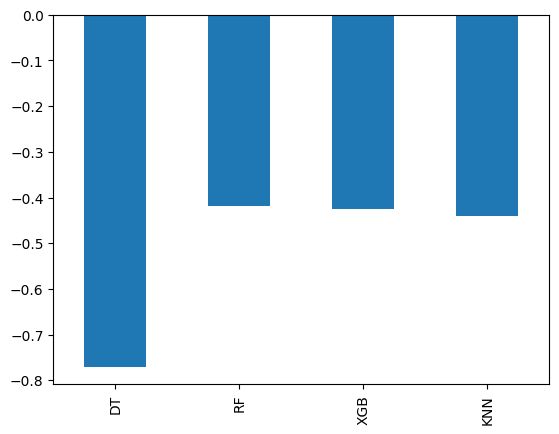

In [ ]:
# 모델평가프로그램
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import numpy as np
k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.model_selection import cross_val_score

model_dict = {'DT': DecisionTreeRegressor(),
              'RF': RandomForestRegressor(),
              'XGB': xgb.XGBRegressor(),
              'KNN': KNeighborsRegressor()}

score = {}

for model_name in model_dict.keys():

    model = model_dict[model_name]

    score[model_name] = np.mean(cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = k_fold))

    print(f'{model_name} 평가 완료')

pd.Series(score).plot(kind = 'bar')

In [ ]:
# 7. 테스트 데이터에 모델 적용 및 결과 제출
from sklearn.neighbors import KNeighborsRegressor
model.fit(X_train, y_train)
submission['count'] = model.predict(X_test)
submission.to_csv('submission_yj3.csv', index=False)

NameError: name 'X_test' is not defined